In [92]:
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!conda install -c conda-forge spacy

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
df = pd.read_csv('train.csv')

In [3]:
df = df.dropna()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [26]:
# exctract word2vec vectors
import spacy
nlp = spacy.load('en')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

ModuleNotFoundError: No module named 'spacy'

In [25]:
!conda install -c conda-forge spacy

Solving environment: ...working... done

# All requested packages already installed.



In [10]:
len(word2tfidf)

109678

In [12]:
len(questions)

808574

In [14]:
len(tfidf.idf_)

109678

In [19]:
tfidf.idf_

array([10.04915183,  7.30458362, 13.90988154, ..., 13.50441643,
       13.50441643, 13.50441643])

In [7]:
from collections import Counter

In [8]:
#Combine all questions into corpus for TFIDF analysis
train_questions = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
#print ("Most common words: "), (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

MemoryError: 

In [21]:
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [22]:
df['TFIDF_share'] = df.apply(tfidf_word_share_norm, axis=1, raw=True)

NameError: ("name 'weights' is not defined", 'occurred at index 0')

In [9]:
df_1 = pd.read_pickle('TFIDF_dataframe.pkl')

In [10]:
df_1.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66.0,57.0,14,12,0.434783,0.400611
1,51.0,88.0,8,13,0.200000,0.193056
2,73.0,59.0,14,10,0.166667,0.149204
3,50.0,65.0,11,9,0.000000,0.000000
4,76.0,39.0,13,7,0.100000,0.009949


In [11]:
df_2 = pd.read_pickle('quora_preprocess.pkl')

In [12]:
df_2.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [13]:
df_2['TFIDF_share'] = df_1['TFIDF_share']

In [15]:
df_2_copy = df_2.copy()

In [16]:
df_2 = df_2.drop(['id','qid1', 'question1','question2', 'is_duplicate'], 1)

In [17]:
df_2.head()

,qid2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,TFIDF_share
0,2,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.400611
1,4,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.193056
2,6,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.149204
3,8,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000
4,10,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.009949


In [20]:
df_3 = pd.read_pickle('cosine_distance.pkl')

In [22]:
df_3.head()

,cosine_distance
0,0.895532
1,0.410995
2,0.225765
3,0.000000
4,0.168368


In [23]:
df_2['cosine_distance'] = df_3['cosine_distance']

In [24]:
df_2.head()

,qid2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,TFIDF_share,cosine_distance
0,2,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.400611,0.895532
1,4,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.193056,0.410995
2,6,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.149204,0.225765
3,8,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000
4,10,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.009949,0.168368


In [25]:
final = pd.DataFrame()

In [26]:
final = df_2.copy()

In [27]:
final['is_duplicate'] = df['is_duplicate']

In [29]:
final.to_pickle('qoura_final.pkl')

In [43]:
final = final.dropna()

In [44]:
final.isnull().sum()

qid2               0
freq_qid1          0
freq_qid2          0
q1len              0
q2len              0
q1_n_words         0
q2_n_words         0
word_Common        0
word_Total         0
word_share         0
freq_q1+q2         0
freq_q1-q2         0
TFIDF_share        0
cosine_distance    0
is_duplicate       0
dtype: int64

In [50]:
final = final.drop(['qid2'], 1)

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

final.isnull().sum

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [52]:
x = final.drop(['is_duplicate'], 1)
y = final['is_duplicate']

In [55]:
x[x.columns] = sc.fit_transform(x[x.columns])

In [56]:
x.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,TFIDF_share,cosine_distance
0,-0.407276,-0.33964,0.215861,-0.091795,0.562482,0.129116,1.771215,0.218073,1.647405,-0.426197,-0.355776,1.426366,1.612815
1,0.261259,-0.33964,-0.285132,0.823644,-0.542098,0.287569,-0.165119,-0.131065,-0.182052,-0.096203,0.222494,-0.062715,-0.115982
2,-0.407276,-0.33964,0.449658,-0.032735,0.562482,-0.187790,-0.165119,0.334452,-0.441790,-0.426197,-0.355776,-0.377328,-0.776874
3,-0.407276,-0.33964,-0.318531,0.144447,0.010192,-0.346242,-1.456008,-0.247444,-1.740479,-0.426197,-0.355776,-1.447773,-1.582388
4,0.038414,-0.33964,0.549857,-0.623340,0.378385,-0.663148,-0.810563,-0.131065,-0.961265,-0.206201,0.029737,-1.376394,-0.981660


In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [ ]:
log = LogisticRegression()
dct = DecisionTreeClassifier()


In [49]:
best_params_logreg = []
parameters = {'loss':['log'],'penalty':['l1','l2','elasticnet'],'alpha':[0.001,0.01,0.1, 1], 'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf,parameters,cv = 5)
clf.fit(x_train,y_train)
best_params_logreg.append(clf.best_params_)
print (best_params_logreg)

[{'alpha': 0.1, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}]


In [94]:
clf = SGDClassifier(loss= 'log',penalty = 'l2',alpha = 0.1,n_jobs = -1)
#choose best parameters
score = cross_val_score(clf,x_train,y_train,cv = 5)

In [61]:
print (sum(score)/len(score

0.7296219064365761


In [62]:
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[64698, 11848],
       [21286, 23455]], dtype=int64)

In [64]:
accuracy_score(y_test, y_pred)

0.7268132611079505

In [77]:
best_params_rf = []
parameters = {'loss':['log'],'penalty':['l1','l2','elasticnet'],'alpha':[0.001,0.01,0.1, 1], 'n_jobs':[-1]}

clf = RandomForestClassifier()
clf = GridSearchCV(clf,parameters,cv = 5)
clf.fit(x_train,y_train)
best_params_rf.append(clf.best_params_)
print (best_params_rf)

ValueError: Invalid parameter alpha for estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [66]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [67]:
accuracy_score(y_test, y_pred_rf)

0.8071681218927008

In [69]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85     76546
         1.0       0.77      0.68      0.72     44741

   micro avg       0.81      0.81      0.81    121287
   macro avg       0.80      0.78      0.79    121287
weighted avg       0.80      0.81      0.80    121287



In [87]:
y_pred_proba_rf  = rf.predict_proba(x_test)[:,1]

In [75]:
#ROC for a given alpha for log reg
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = rf.predict_proba(y_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print ("Precision :",precision)
print ("Recall :",recall)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

0.8924211019980572


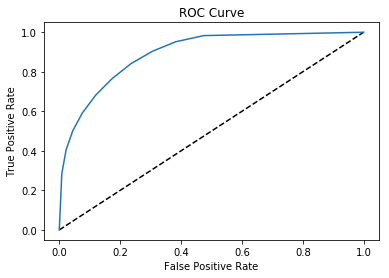

In [93]:
# AUC curve for Random Forest
y_pred_proba_rf  = rf.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve,roc_auc_score
fpr_lr,tpr_lr,thresholds = roc_curve(y_test,y_pred_proba_rf)
print(roc_auc_score(y_test,y_pred_proba_rf))# Iterate over probabiliteis and not y_pred

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [88]:
y_pred_proba_rf.shape

(121287,)

In [89]:
y_test.shape

(121287,)

In [95]:
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

0.8319518175595708


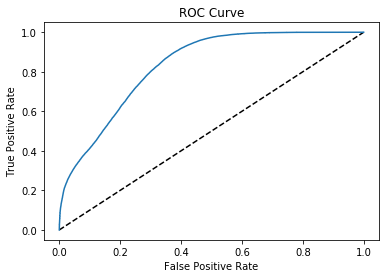

In [97]:
y_pred_proba_clf  = clf.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve,roc_auc_score
fpr_lr,tpr_lr,thresholds = roc_curve(y_test,y_pred_proba_clf)
print(roc_auc_score(y_test,y_pred_proba_clf))# Iterate over probabiliteis and not y_pred

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()